# Support Points and Privacy

_____

In [1]:
# Toggle which experiments to run.
DO_EXPERIMENT_SP = 0
DO_EXPERIMENT_TF = 1

## PART 1: 
## Empirical distance between support points Y and leave-one-out \[LOO\] support points (Y')

"""
Computes max discrepancy of support points due to single-point omission.

For data X, and support points Y:
M(X, m) --> Y
M(X', m) --> Y'
Compute Pr(d(Y, Y') > eps) < delta

let eps = (1-delta)th percentile of max_discrepancies
"""


In [2]:
%matplotlib inline

import argparse
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import numpy as np
import os
import pdb
import sys
import time
import tensorflow as tf

from scipy.stats import ks_2samp

In [3]:
def sample_gaussian(n):
    mean, loc = 0, 1
    return np.random.normal(mean, loc, n)

def sample_gamma(n):
    k, theta = 1, 10
    return np.random.gamma(k, theta, n)

In [4]:
def generate_data(n, data_source):
    '''Generates data.
    Args:
      n: Number of data candidates.
      data_source: String flag for which data_source to use.
    Returns:
      data: Numpy array of points.
    '''
    if data_source == 'gaussian':
        two_modes = 0
        if two_modes:
            n_c2 = n/2
            n_c1 = n - n_c2
            data = np.concatenate((np.random.normal(0, 1, n_c1),
                                   np.random.normal(6, 1, n_c2)))
        else:
            data = sample_gaussian(n)
    elif data_source == 'gaussian_with_outlier':
        n_c1 = 1
        n_c2 = 0
        n_c3 = n - (n_c1 + n_c2)
        data = np.concatenate((np.random.normal(8, 1, n_c1),
                               np.random.normal(-8, 1, n_c2),
                               np.random.normal(0, 1, n_c3)))
    elif data_source == 'gamma':
        data = sample_gamma(n)
    elif data_source == 'file':
        with open('samp.dat') as f:
            data = [line.split() for line in f]
            data = np.array([float(d[1]) for d in data if len(d) == 2])
    elif data_source == 'correlated':
        data = np.zeros(n)
        data[0] = np.random.normal()
        for i in xrange(1, n):
            data[i] = (data[i - 1] * corr +
                np.sqrt(1 - corr**2) * np.random.normal())

        plt.subplot(211);
        plt.plot(data)
        plt.subplot(212);
        plt.hist(data, 30)
        plt.savefig('orig_data.png'); plt.close()

        if test_correlated:
            x_bars = []
            for i in range(1000):
                data = np.zeros(n)
                data[0] = np.random.normal()
                for i in xrange(1, n):
                    data[i] = (data[i - 1] * corr +
                        np.sqrt(1 - corr**2) * np.random.normal())
                x_bars.append(np.mean(
                    np.random.choice(data, num_support, replace=False)))
            print('num support = {}'.format(num_support))
            print('1/{} = {}'.format(num_support, 1./num_support))
            print('var(x_bars) = {}'.format(np.var(x_bars)))
            sys.exit('exited on test_correlated within generate_data')
    else:
        sys.exit('--data_source not valid')
        
    return data

In [5]:
def energy(data, gen, sigma=1.):
    '''Computes abbreviated energy statistic between two point sets.
    
    The smaller the value, the closer the sets.
    Args:
      data: 1D numpy array of any length, e.g. 100.
      gen: 1D numpy array of any length, e.g. 10.
      sigma: Float, kernel lengthscale.
    Returns:
      e: Scalar, the energy between the sets.
      mmd: Scalar, the mmd between the sets.
      gradients_e: Numpy array of energy gradients for each proposal point.
      gradients_mmd: Numpy array of mmdgradients for each proposal point.
    '''
    x = sorted(list(data))
    y = sorted(list(gen))
    data_num = len(x)
    gen_num = len(y)
    num_combos_xx = data_num * (data_num - 1) / 2.
    num_combos_yy = gen_num * (gen_num - 1) / 2.


    # Compute energy.
    v = np.concatenate((x, y), 0)
    v_vert = v.reshape(-1, 1)
    v_tiled = np.tile(v_vert, (1, len(v)))
    pairwise_difs = v_tiled - np.transpose(v_tiled)
    energy = abs(pairwise_difs)
    energy_xx = energy[:data_num, :data_num]
    energy_yy = energy[data_num:, data_num:]
    energy_yx = energy[data_num:, :data_num]
    e = (2. / gen_num / data_num * np.sum(energy_yx) -
         1. / data_num / data_num * np.sum(energy_xx) -
         1. / gen_num / gen_num * np.sum(energy_yy))

    """
    # Compute MMD.
    pairwise_prods = np.matmul(v_vert, np.transpose(v_vert))
    sqs_vert = np.reshape(np.diag(pairwise_prods), [-1, 1])
    sqs_vert_tiled_horiz = np.tile(sqs_vert, (1, data_num + gen_num))
    exp_object = (sqs_vert_tiled_horiz - 2 * pairwise_prods +
                  np.transpose(sqs_vert_tiled_horiz))
    
    K = np.exp(-0.5 / sigma * exp_object)
    K_xx = K[:data_num, :data_num]
    K_yy = K[data_num:, data_num:]
    K_xy = K[:data_num, data_num:]
    K_xx_upper = np.triu(K_xx, 1)
    K_yy_upper = np.triu(K_yy, 1)
    mmd = (1. / num_combos_xx * np.sum(K_xx_upper) +
           1. / num_combos_yy * np.sum(K_yy_upper) -
           2. / data_num / gen_num * np.sum(K_xy))
    """

    # Compute energy gradients.
    # TODO: CHECK WHETHER THIS GRADIENT IS CORRECT.
    signed = np.sign(pairwise_difs)
    signed_yx = signed[data_num:, :data_num]
    signed_yy = signed[data_num:, data_num:]
    gradients_e = []
    for i in range(gen_num):
        grad_yi = (2. / gen_num / data_num * sum(signed_yx[i]) - 
                   2. / gen_num / gen_num * sum(signed_yy[i]))
        gradients_e.append(grad_yi)
    gradients_e[0] *= 2
    gradients_e[-1] *= 2
    
    """
    # Compute MMD gradients.
    mmd_grad = K * (-1. / sigma * pairwise_difs)
    mmd_grad_yx = mmd_grad[data_num:, :data_num] 
    mmd_grad_yy = mmd_grad[data_num:, data_num:] 
    mmd_grad_yy_upper = np.triu(mmd_grad_yy, 1)
    gradients_mmd = []
    for i in range(gen_num):
        grad_yi = (1. / num_combos_yy * 
                       (sum(mmd_grad_yy_upper[i]) -
                        sum(mmd_grad_yy_upper[:, i])) -
                   2. / gen_num / data_num * sum(mmd_grad_yx[i]))
                   
        gradients_mmd.append(grad_yi)
    """

    return e, np.array(gradients_e)

In [6]:
def optimize(data, gen, n=500, learning_rate=1e-2):
    '''Runs alternating optimizations, n times through proposal points.
    Args:
      data: 1D numpy array of any length, e.g. 100.
      gen: 1D numpy array of any length, e.g. 10.
      n: Scalar, number of times to loop through updates for all vars.
      learning_rate: Scalar, amount to move point with each gradient update.
      
    Returns:
      y_out: 2D numpy array of trace of generated proposal points.
      e_out: Float, energy between data and last iteration of y_out.
    '''
    max_tries = 3
    tries = 0
    valid_output = False

    while tries <= max_tries:
        y_out = np.zeros((n, len(gen)))
        for it in range(n):
            e_out, grads_e_ = energy(data, gen) 
            grads_ = grads_e_
            gen -= learning_rate * grads_
            y_out[it, :] = gen

            if it % save_iter == 0 or it == (n - 1):
                if verbose:
                    print('  it{}: e: {:.4f}, mmd: {:.4f}'.format(it, e_out, mmd_))
                    print('  P: min,med,mean,max: {:2f},{:2f},{:2f},{:2f}'.format(
                        np.min(data), np.median(data), np.mean(data),
                        np.max(data)))
                    g = y_out[it]
                    print('  G: min,med,mean,max: {:2f},{:2f},{:2f},{:2f}'.format(
                        np.min(g), np.median(g), np.mean(g), np.max(g)))
        
        tries += 1
        if e_out < 5:
            valid_output = True
            break
        else:
            print('REDOing optimize after e_={:.2f}'.format(e_out))

    # At this point, optimization did not converge. Set symbolic "bad" value.
    if not valid_output:
        e_out = -999

    return y_out, e_out

In [7]:
def plot_single_run(y_out, e_out, p, num_support,
                    percentiles=None):
    data_markers_x = [y_out.shape[0]] * len(p)
    data_markers_y = p
    plt.scatter(data_markers_x, data_markers_y, marker='x', label='data')
    plt.plot(y_out, 'k-', alpha=0.3)
    if percentiles is not None:
        plt.scatter([1.05 * y_out.shape[0]] * y_out.shape[1],
                    percentiles, color='blue', label='pct')
    plt.legend(loc='upper left')
    plt.title('|data|=n={}, |support|=m={}, e(x,y)={:.4f}'.format(
              len(p), num_support, e_out))
    plt.savefig('support_points_path.png');
    plt.show()

In [8]:
def get_support_points(data, num_support, max_iter, lr, plot=False,
                       percentiles=None):
    # Initialize generated particles for both sets (x0 and x1).
    x = data
    y = num_support
    
    y_orig_offset = 1e-1
    y = list(np.linspace(min(x) + y_orig_offset,
                         max(x) - y_orig_offset,
                         m))
   
    # Optimize particles for each dataset (x0 and x1).
    y_out, e_out = optimize(x, y, n=max_iter, learning_rate=lr)

    # Get last updated set as support points.
    sp = y_out[-1]
    
    # Plot optimization.
    if plot:
        plot_single_run(y_out, e_out, x, m,
                        percentiles=percentiles)
        
    return sp

In [9]:
def measure_eps(discrepancies, delta):
    eps = np.percentile(discrepancies, 100*(1 - delta))
    print('\nPr(d(Y, Y\') > {:.2f}) < {:.2f}'.format(eps, delta))

In [10]:
def eval_with_baseline(data_source, max_discs_y_y_,
                       max_discs_x_y_, min_pstats_x_y_,
                       n, m):
    """Shows how well support points fit true distribution.
    
    Compares X_m and Y_m' to distribution X.
    
    Args:
      data_source: String, indicates which distribution to sample.
      max_discs_y_y_: Array, privacy discrepancies.
      max_discs_x_y_: Array, utility discrepancies.
      min_pstats_x_y_: Array, utility KS p-statistics.
      n: Int, number of points from reference distribution.
      m: Int, number of points from testing distribution.
    """
    if data_source == 'gaussian':
        sample = sample_gaussian
    elif data_source == 'gamma':
        sample = sample_gamma
    
    # Get discs for X (n samples) and Xm (m samples).
    num_trials = len(max_discs_x_y_)
    discs_x_xm, pstats_x_xm = (
        zip(*(ks_2samp(sample(n), sample(m)) for _ in range(num_trials))))
    
    # Compare discrepancies.
    plt.hist([max_discs_y_y_, max_discs_x_y_, discs_x_xm], histtype='bar',
             bins=20, label=['d(Y, Y\')', 'd(X, Y\')', 'd(X, X_m)'],
             color=['green', 'blue', 'gray'], alpha=0.3)
    plt.title('Baseline comparison: KS distances')
    plt.legend()
    plt.show()
    
    # Compare p-statistics of Y_m' and X_m, each to X.
    plt.hist([pstats_x_xm, min_pstats_x_y_], bins=20,
             label=['Xm diff from X?', 'Y\' diff from X?'],
             color=['blue', 'green'], alpha=0.3)
    plt.title('Baseline comparison: KS p-stats')
    plt.legend()
    plt.show()
    
    tail = 5
    print('max_discs_y_y_: {}'.format(np.round(sorted(max_discs_y_y_), 3)[-tail:]))
    print('max_discs_x_y_: {}'.format(np.round(sorted(max_discs_x_y_), 3)[-tail:]))
    print('max_discs_x_xm_: {}'.format(np.round(sorted(discs_x_xm), 3)[-tail:]))
    
    print('min_pstats_x_xm: {}'.format(np.round(sorted(pstats_x_xm), 3)[:tail]))
    print('min_pstats_x_y_: {}'.format(np.round(sorted(min_pstats_x_y_), 3)[:tail]))
    pdb.set_trace()

In [11]:
def run_trial(data_source, n, m, max_iter, plot=False, single_run=False):
    """Findssupport point discrepancies due to single-point omission.
    
    Args:
      data_source: String, identifier for dataset to use.
      n: Int, number of data points in X. So X' has n-1.
      m: Int, number of support points in Y and Y'.
      max_iter: Number of iterations in support point optimization.
    """
    # Sample n from reference distribution.
    if data_source == 'gaussian':
        x = sample_gaussian(n)
    elif data_source == 'gamma':
        x = sample_gamma(n)
    else:
        print('Set up fn for unknown data_source')
        sys.exit()

    # Compute m support points on full set.
    percentiles = np.percentile(
        x, np.linspace(1./(m+1), 1 - 1./(m+1), m) * 100)  # middle m percentiles
    y = get_support_points(x, m, max_iter, lr, plot=plot,
                           percentiles=percentiles)
    #y = percentiles

    # Collect outputs for Y and Y', and for X and Y'.
    discs_y_y_ = []
    discs_x_y_ = []
    pstats_x_y_ = []

    # Compare support points on full set vs single-point omission set.
    for removed_index in range(n):

        # Remove the current index to make the "neighboring" set.
        x_ = [v for i,v in enumerate(x) if i != removed_index]

        # Get support points for each set X, X' and report distance.
        plot = True if (plot and removed_index in [0]) else False

        percentiles_ = np.percentile(x_, np.linspace(1./(m+1), 1 - 1./(m+1), m) * 100)  # middle m percentiles
        y_ = get_support_points(x_, m, max_iter, lr, plot)
        #y_ = percentiles_
        
        # Get dist between full-set and single-point omission support points.
        disc_y_y_, _ = ks_2samp(y, y_)
        disc_x_y_, pstat_x_y_ = ks_2samp(x, y_)
        
        # Add results to list for this sample x.
        discs_y_y_.append(disc_y_y_)
        discs_x_y_.append(disc_x_y_)
        pstats_x_y_.append(pstat_x_y_)
        
        if plot:
            # eCDF of Y and Y'.
            plt.scatter(x[removed_index], 0.0, label='pt removed')
            plt.step(np.sort(y), np.arange(1, len(y) + 1) / float(len(y)),
                     label='y', color='blue', alpha=0.7, where='post')
            plt.step(np.sort(y_), np.arange(1, len(y_) + 1) / float(len(y_)),
                     label='y_', color='green', alpha=0.7, where='post')
            plt.legend()
            plt.ylim((-0.1, 1.1))
            plt.title('CDFs. KS(Ym, Ym_) = {:.3f}'.format(disc_y_y_))
            plt.show()
            
            # eCDF of percentiles and percentiles_.
            plt.scatter(x[removed_index], 0.0, label='pt removed')
            plt.step(percentiles, np.arange(1, len(percentiles) + 1) / float(len(percentiles)),
                     label='pct', color='blue', alpha=0.7, where='post')
            plt.step(percentiles_, np.arange(1, len(percentiles_) + 1) / float(len(percentiles_)),
                     label='pct_', color='green', alpha=0.7, where='post')
            plt.legend()
            plt.ylim((-0.1, 1.1))
            plt.title('CDFs. Percentiles.'.format(disc_y_y_))
            plt.show()
            
            # eCDF of X and Y'.
            plt.scatter(x[removed_index], 0.0, label='pt removed')
            plt.step(np.sort(x), np.arange(1, len(x) + 1) / float(len(x)),
                     label='x', color='gray', alpha=0.5, where='post')
            plt.step(np.sort(y_), np.arange(1, len(y_) + 1) / float(len(y_)),
                     label='y_', color='green', alpha=0.7, where='post')
            plt.legend()
            plt.ylim((-0.1, 1.1))
            plt.title('CDFs. KS(Xn, Ym_) = {:.3f}'.format(disc_x_y_))
            plt.show()

            print('x: {}'.format(np.round(sorted(x), 2)))
            print('y: {}'.format(np.round(sorted(y), 2)))
            print('y_: {}'.format(np.round(sorted(y_), 2)))

        if single_run:
            break

    return discs_y_y_, discs_x_y_, pstats_x_y_

## Run support point vs. LOO support point experiment.

In [12]:
n = 100
m = 10
lr = 1.
max_iter = 100
data_source = 'gaussian'

num_trials = 100

delta = 0.05  # Probability of exposing a single point.
corr = 0.8
save_iter = 50
test_correlated = False
verbose = False


def main():
    start_time =  time.time()
    
    # Run trials.
    max_discs_y_y_ = []
    max_discs_x_y_ = []
    min_pstats_x_y_ = []

    for i in range(num_trials):
        if i % 10 == 0:
            print('Run {}'.format(i))
    
        # Get discrepancies for privacy and utility pairs.
        plot = True if i == 0 else False  # Plot only on first exp.

        # Runs trial for one sample X, and all LOO Y's.
        discs_y_y_, discs_x_y_, pstats_x_y_ = run_trial(
            data_source, n, m, max_iter, plot=plot)
        
        max_discs_y_y_.append(np.max(discs_y_y_))
        max_discs_x_y_.append(np.max(discs_x_y_))
        min_pstats_x_y_.append(np.min(pstats_x_y_))
    
    # Utility: How does Y_m' compare to X_m, in belonging to X? 
    eval_with_baseline(data_source, max_discs_y_y_, 
                       max_discs_x_y_, min_pstats_x_y_,
                       n, m)
    
    # Privacy: How close is Y_m' to Y_m?
    measure_eps(max_discs_y_y_, delta)
    
    end_time = time.time()
    print('Time elapsed: {:.1f}s'.format(end_time - start_time))

    pdb.set_trace()

if DO_EXPERIMENT_SP:
    main()

____

## PART 2:
## TensorFlow attack. Identify missing Xi.

#### Build the training set of datasets and their support points.

In [13]:
import numpy as np

def build_nn_training_set(CONFIG):
    n = CONFIG['energy_n']
    m = CONFIG['energy_m']
    lr = CONFIG['energy_lr']
    max_iter = CONFIG['energy_max_iter']
    data_source = CONFIG['data_source']
    data_size = CONFIG['tf_data_size']
    
    assert data_source == 'gaussian', 'Temporarily only Gaussian(0,1)'
    
    data = np.zeros((data_size, n + m + 1))  # Add one for removed index.
    for row in range(data_size):
        x = np.random.normal(0, 1, size=n)
        removed_index = np.random.choice(range(n))
        x_ = [v for i,v in enumerate(x) if i != removed_index]
        y_ = get_support_points(x_, m, max_iter, lr)
        
        # Assemble example with original data, LOO support points,
        # and removed index.
        data[row] = np.concatenate((np.sort(x), np.sort(y_), [removed_index]))
    
    dim_x, dim_y = n, m
    data_train = data[:int(0.8 * data.shape[0])]
    data_test = data[int(0.8 * data.shape[0]):]
    
    np.save('nn_training_set.npy', data_train)
    return data_train, data_test, dim_x, dim_y

#### Build the TF graph and train.

In [14]:
def run_tf(CONFIG, data_train, data_test):
    import tensorflow as tf
    tf.reset_default_graph()
    
    width = CONFIG['tf_width']
    depth = CONFIG['tf_depth']
    lr = CONFIG['tf_lr']
    max_iter = CONFIG['tf_max_iter']
    optimizer = CONFIG['tf_optimizer']
    activation = CONFIG['tf_activation']
    regularizer = CONFIG['tf_regularizer']

    # Set up config for neural network.
    data_train_inputs, data_train_labels = data_train[:,:-1], data_train[:,-1]
    data_test_inputs, data_test_labels = data_test[:,:-1], data_test[:,-1]
    n_inputs = data_train_inputs.shape[0]


    ###############
    # Build graph.

    # Computation.
    input_data = tf.placeholder(tf.float32, [None, dim_x + dim_y], name='input_data')
    input_labels = tf.placeholder(tf.int32, [None], name='input_labels')
    labels = tf.one_hot(input_labels, dim_x)

    h = input_data
    for d in range(depth):
        h = tf.layers.dense(h, width, activation=activation,
                            activity_regularizer=regularizer)
        h = tf.nn.dropout(h, 0.8)
    logits = tf.layers.dense(h, dim_x)

    # Loss and optimization.
    loss = tf.reduce_mean(
        tf.losses.softmax_cross_entropy(labels, logits))
    opt = optimizer(lr)
    grads_, vars_ = zip(*opt.compute_gradients(
        loss,var_list=tf.trainable_variables()))
    grads_clipped_ = tuple([tf.clip_by_value(g, -0.01, 0.01) for g in grads_])
    optim = opt.apply_gradients(zip(grads_clipped_, vars_))

    # Performance.
    prediction = tf.nn.softmax(logits)
    correct_prediction = tf.equal(tf.argmax(prediction, 1), tf.argmax(labels, 1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    #############

    # Train.
    init_op = tf.global_variables_initializer()
    gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
    sess_config = tf.ConfigProto(allow_soft_placement=True, gpu_options=gpu_options)
    with tf.Session(config=sess_config) as sess:
        sess.run(init_op)

        for i in range(max_iter):
            acc_train_, loss_, _ = sess.run([accuracy, loss, optim], 
                                {input_data: data_train_inputs,
                                 input_labels: data_train_labels})

            if i % 1000 == 0:
                acc_test_ = sess.run(accuracy, 
                                     {input_data: data_test_inputs,
                                      input_labels: data_test_labels})

                print(('Iter: {}. , Loss={:.3f}, Acc_train={:.3f}, '
                       'Acc_test={:.3f}').format(i, loss_, acc_train_, acc_test_))

In [20]:
CONFIG = {
    'energy_n': 50,
    'energy_m': 10,
    'energy_lr': 1.,
    'energy_max_iter': 100,
    'data_source': 'gaussian',
    'tf_data_size': 250,
    'tf_lr': 1e-3,
    'tf_max_iter': 500000,
    'tf_optimizer': tf.train.AdamOptimizer,
    'tf_activation': tf.nn.relu,
    'tf_regularizer': tf.contrib.layers.l1_regularizer(1.),  # [None, tf.contrib.layers.l1_regularizer(0.001)]
    'tf_width': 100,
    'tf_depth': 20,
}



Trial run for support points. Check for convergence before proceeding.


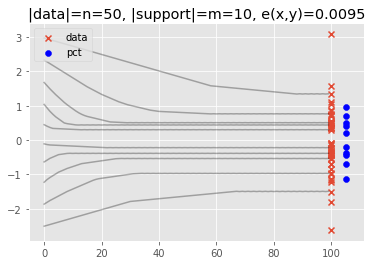

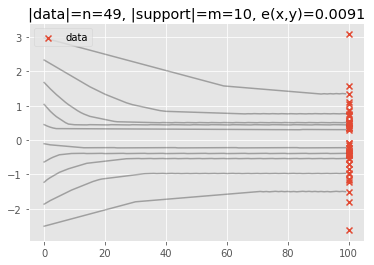

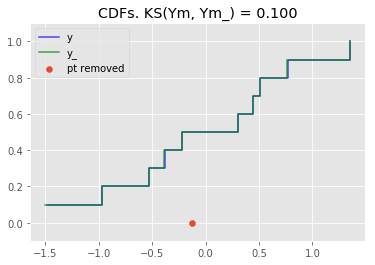

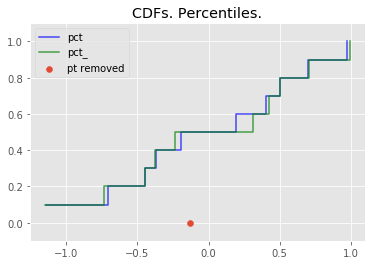

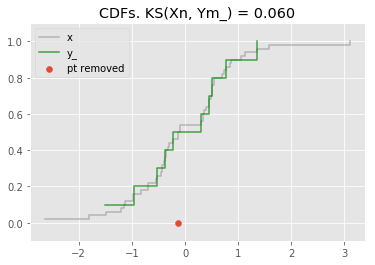

x: [-2.63 -1.8  -1.5  -1.21 -1.15 -1.14 -0.98 -0.97 -0.84 -0.7  -0.69 -0.55
 -0.53 -0.44 -0.44 -0.44 -0.4  -0.39 -0.37 -0.36 -0.32 -0.3  -0.22 -0.14
 -0.13 -0.09 -0.09  0.3   0.35  0.35  0.35  0.4   0.44  0.45  0.49  0.5
  0.5   0.51  0.54  0.55  0.69  0.73  0.77  0.84  0.87  1.06  1.12  1.35
  1.58  3.1 ]
y: [-1.49 -0.97 -0.53 -0.38 -0.22  0.3   0.44  0.51  0.77  1.35]
y_: [-1.5  -0.97 -0.53 -0.39 -0.22  0.3   0.44  0.51  0.77  1.35]


[Generating training data for TensorFlow prediction model.]


Training TensorFlow prediction model.
Iter: 0. , Loss=3.912, Acc_train=0.015, Acc_test=0.000
Iter: 1000. , Loss=3.139, Acc_train=0.120, Acc_test=0.060
Iter: 2000. , Loss=2.842, Acc_train=0.175, Acc_test=0.000
Iter: 3000. , Loss=2.534, Acc_train=0.245, Acc_test=0.000
Iter: 4000. , Loss=2.421, Acc_train=0.205, Acc_test=0.000
Iter: 5000. , Loss=2.384, Acc_train=0.250, Acc_test=0.000


In [ ]:
if DO_EXPERIMENT_TF:
    print('\n\nTrial run for support points. Check for convergence before proceeding.')
    run_trial(CONFIG['data_source'], CONFIG['energy_n'], CONFIG['energy_m'],
              CONFIG['energy_max_iter'], plot=True)
    
    print('\n\n[Generating training data for TensorFlow prediction model.]')
    data_train, data_test, dim_x, dim_y = build_nn_training_set(CONFIG)
    
    
    print('\n\nTraining TensorFlow prediction model.')
    run_tf(CONFIG, data_train, data_test)